A notebook to generate a river forcing. Constant Fraser river outflow 2000m^3/s.

Based on /data/nsoontie/MEOPAR/NEMO-forcing/rivers/Fraser_only_cnst.nc

Uses a runoff temperaure of 14 deg to avoid runaway temperatures.

In [1]:
import netCDF4 as nc
import numpy as np

from salishsea_tools import nc_tools

import matplotlib.pyplot as plt

%matplotlib inline

# 3D constant forcing

First look at the constant Fraser river forcing file. 

In [2]:
river = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/rivers/rivers_Fraser_only_cnst.nc')

In [3]:
nc_tools.show_variables(river)

KeysView(OrderedDict([('nav_lat', <class 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
unlimited dimensions: 
current shape = (898, 398)
filling off
), ('nav_lon', <class 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
unlimited dimensions: 
current shape = (898, 398)
filling off
), ('time_counter', <class 'netCDF4._netCDF4.Variable'>
float32 time_counter(time_counter)
    units: non-dim
unlimited dimensions: time_counter
current shape = (1,)
filling off
), ('rorunoff', <class 'netCDF4._netCDF4.Variable'>
float32 rorunoff(time_counter, y, x)
    _Fillvalue: 0.0
    _missing_value: 0.0
    _units: kg m-2 s-1
unlimited dimensions: time_counter
current shape = (1, 898, 398)
filling off
), ('rodepth', <class 'netCDF4._netCDF4.Variable'>
float32 rodepth(y, x)
    _Fillvalue: -1.0
    missing_value: -1.0
    units: m
unlimited dimensions: 
current shape = (898, 398)
filling off
)]))


In [4]:
run_off_3D = river.variables['rorunoff'][0,:,:]
depth_3D =river.variables['rodepth'][:]

In [5]:
inds = np.where(run_off_3D != 0.0)

In [6]:
run_off_3D[inds]

array([ 2.31223202,  4.62446404,  2.31223202], dtype=float32)

In [8]:
total_run_off_3D = np.sum(run_off_3D[inds])
print(total_run_off_3D)

9.24893


In [9]:
np.max(depth_3D)

3.0

Dishcharge distrubuted across three different points.

Plan: add these up and distrubute across right end of my domain.

# Towards 2D files

Load bathymetry

In [11]:
fB=nc.Dataset('/data/nsoontie/MEOPAR/2Ddomain/grid/bathy2D_36.nc')

Iniitialize run off arrays

In [27]:
d = fB.variables['Bathymetry'][:]
X = fB.variables['x'][:]
Y=fB.variables['y'][:]
ymax, xmax = d.shape
runoff = np.zeros((ymax, xmax))
run_depth = -np.ones((ymax, xmax)) 
run_temp = -999*np.ones((ymax, xmax)) # -999 means missing data and will use surface temp

TEMP = 14 

Set up parameters

In [25]:
run_off_depth = 3 # fresh water will be added over three metres

Add river to second to last grid cell. Divide discgarge in spanwise, but exlude first and last.

In [26]:
#depth at last grid cell?
print(d[2,-2])

10.25


In [28]:
js=1; je=ymax-2

runoff[js:je+1,xmax-2] = total_run_off_3D/(je-js)
run_depth[js:je+1,xmax-2]= run_off_depth
run_temp[js:je+1,xmax-2]= TEMP

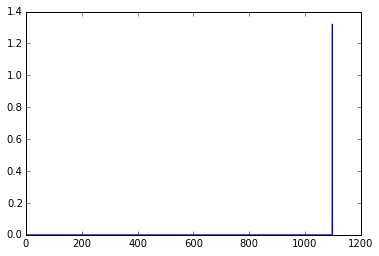

In [29]:
plt.plot(runoff[1,:])

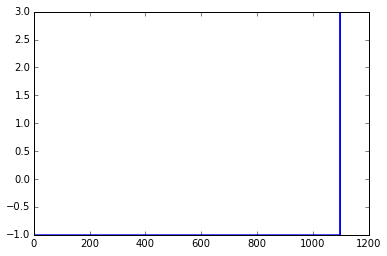

In [30]:
plt.plot(run_depth[1,:])

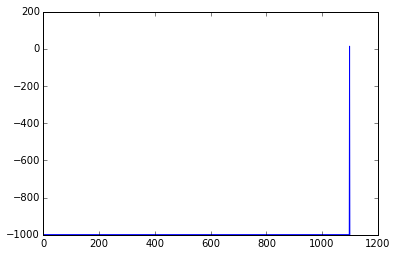

In [31]:
plt.plot(run_temp[1,:])

# Create netcdf file

In [32]:
nemo = nc.Dataset('../rivers/river_cnst.nc', 'w')
nemo.description = 'Constant Yearly Average, One River' 
# dimensions
nemo.createDimension('x', xmax)
nemo.createDimension('y', ymax)
nemo.createDimension('time_counter', None)
    
# variables
y = nemo.createVariable('y','float32',('y','x'),zlib=True)
y = Y
x = nemo.createVariable('x','float32',('y','x'),zlib=True)
x = X
    # time
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
time_counter.units = 'non-dim'
time_counter[0] = 1
# runoff
rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
rorunoff._Fillvalue = 0.
rorunoff._missing_value = 0.
rorunoff._units = 'kg m-2 s-1'
rorunoff[0,:] = runoff
# depth
rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
rodepth._Fillvalue = -1.
rodepth.missing_value = -1.
rodepth.units = 'm'
rodepth[:] = run_depth
# temp
rotemper = nemo.createVariable('rotemper','float32',('y','x'),zlib=True)
rotemper._Fillvalue = -999.
rotemper.missing_value = -999.
rotemper.units = 'deg C'
rotemper[:] = run_temp
nemo.close()